## Import Datasets

In [1]:
import pandas as pd
import numpy as np
import os
import numpy as np
from pydub import AudioSegment
from pydub.utils import mediainfo

animal_name_translation = {'cat':'cat',
                          'dog':'dog',
                          'aslan':'lion',
                          'esek':'donkey',
                          'inek':'cow',
                          'koyun':'baby sheep',
                          'kurbaga':'frog',
                          'Kus':'bird',
                          'maymun':'monkey',
                          'tavuk':'chicken'}

# Define a custom class to store audio data
class AudioFile:
    def __init__(self, file_name, audio_data, sample_rate, label):
        self.file_name = file_name   # Unique Identifier
        self.audio_data = audio_data
        self.sample_rate = sample_rate
        self.label = label

    def __repr__(self):
        return f"AudioFile(file_name={self.file_name}, label={self.label}, sample_rate={self.sample_rate}, audio_data_shape={self.audio_data.shape})"

# Path to the folder containing .wav files
folder_path = "audio_data"

wav_files = []

# List all .wav files in the folder
for folder in os.listdir(folder_path):
    for file in os.listdir(f"{folder_path}\\{folder}"):
        if file.endswith('.wav'):
            wav_files.append(f"{folder}\\{file}")

# Create a list to store AudioFile objects
audio_objects = []

# Load each .wav or .mp3 file and store as an AudioFile object
for wav_file in wav_files:
    file_path = os.path.join(folder_path, wav_file)
    #print(f"Loading {file_path}")

    # Use pydub to read the audio file
    audio = AudioSegment.from_file(file_path)
    y = np.array(audio.get_array_of_samples())  # Convert to numpy array
    y = y.astype(np.float32) / (2**15)  # Normalize to [-1, 1] for 16-bit PCM
    sr = audio.frame_rate  # Get sample rate

    #print(f"Loaded {wav_file} with sample rate {sr} and {len(y)} samples")

    # Extract label from the folder name
    filename = os.path.basename(file_path)
    label = animal_name_translation[filename.split('_')[0]]

    # Create an AudioFile object and store it
    audio_objects.append(AudioFile(wav_file, y, sr, label))

# Check every 100th audio object
for audio_object in audio_objects[::100]:
    print(audio_object)

c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


AudioFile(file_name=Aslan\aslan_1.wav, label=lion, sample_rate=22050, audio_data_shape=(198592,))
AudioFile(file_name=cats_dogs\cat_154.wav, label=cat, sample_rate=16000, audio_data_shape=(162816,))
AudioFile(file_name=cats_dogs\cat_94.wav, label=cat, sample_rate=16000, audio_data_shape=(190400,))
AudioFile(file_name=cats_dogs\dog_barking_82.wav, label=dog, sample_rate=16000, audio_data_shape=(52693,))
AudioFile(file_name=Kedi-Part1\cat_100.wav, label=cat, sample_rate=16000, audio_data_shape=(20696,))
AudioFile(file_name=Kedi-Part2\cat_103.wav, label=cat, sample_rate=16000, audio_data_shape=(192000,))
AudioFile(file_name=Kopek-Part1\dog_22.wav, label=dog, sample_rate=16000, audio_data_shape=(45302,))
AudioFile(file_name=Kopek-Part2\dog_122.wav, label=dog, sample_rate=11025, audio_data_shape=(45820,))
AudioFile(file_name=Kus-Part1\Kus_28.wav, label=bird, sample_rate=44100, audio_data_shape=(44100,))
AudioFile(file_name=Kus-Part2\Kus_122.wav, label=bird, sample_rate=44100, audio_data_sha

## Visualize Waveform

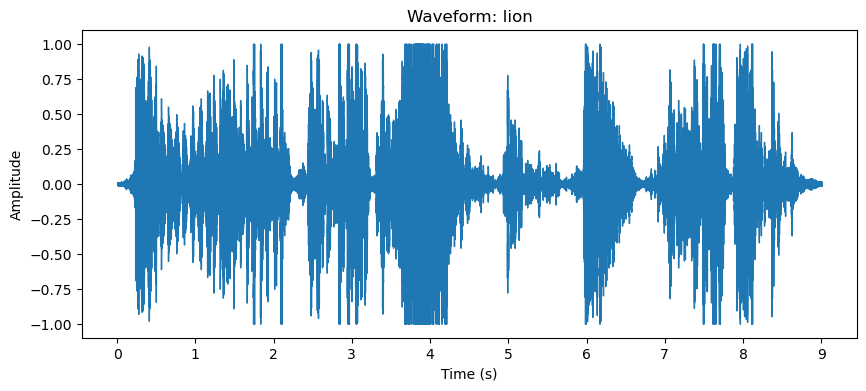

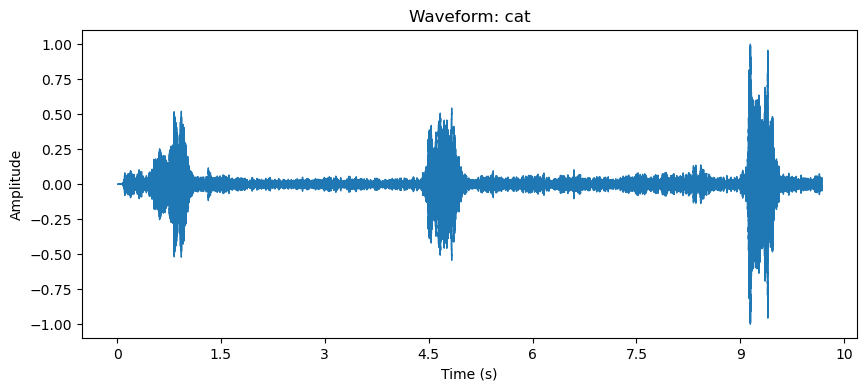

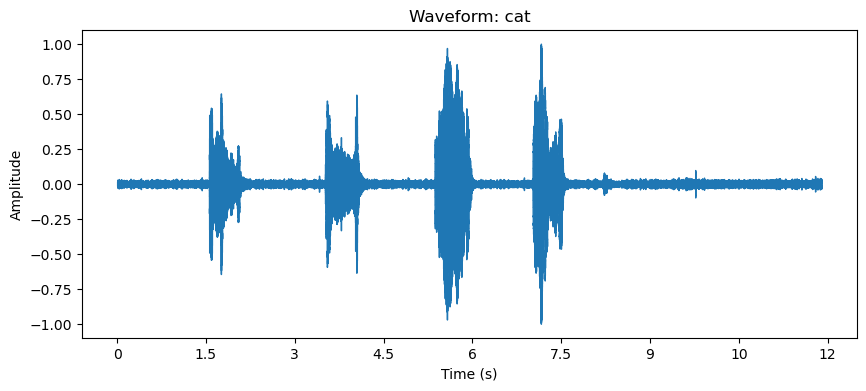

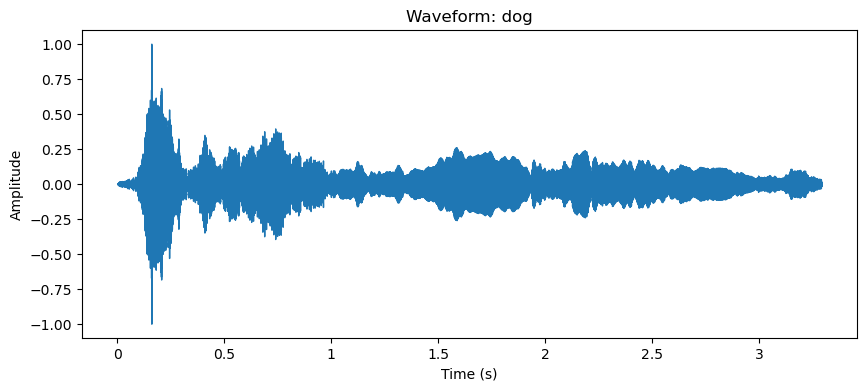

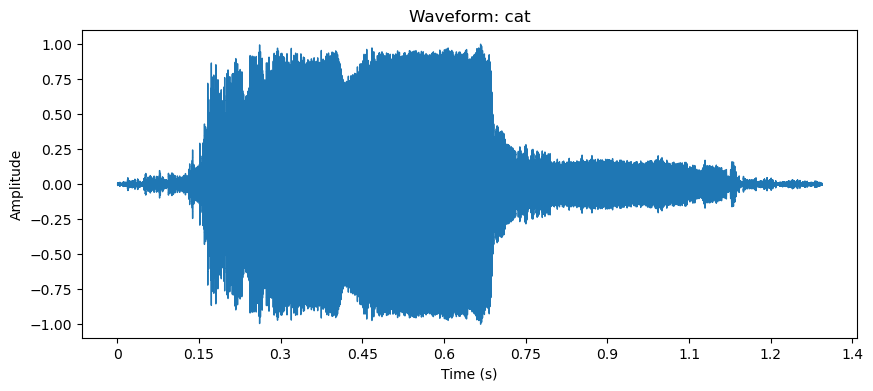

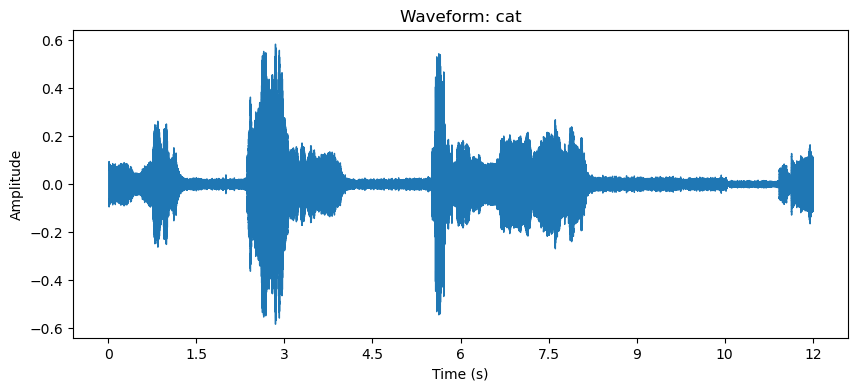

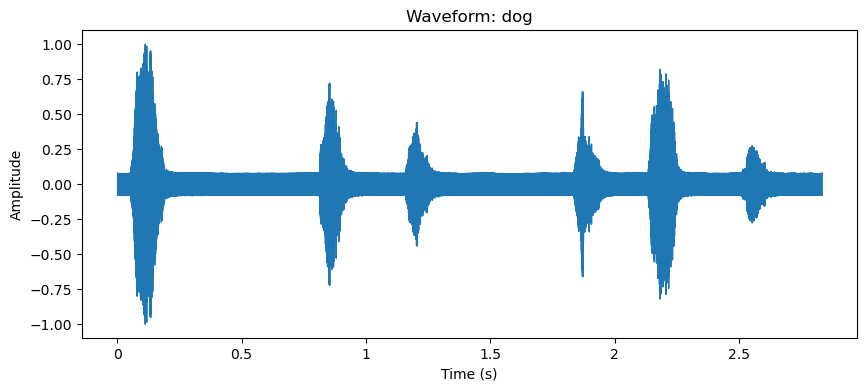

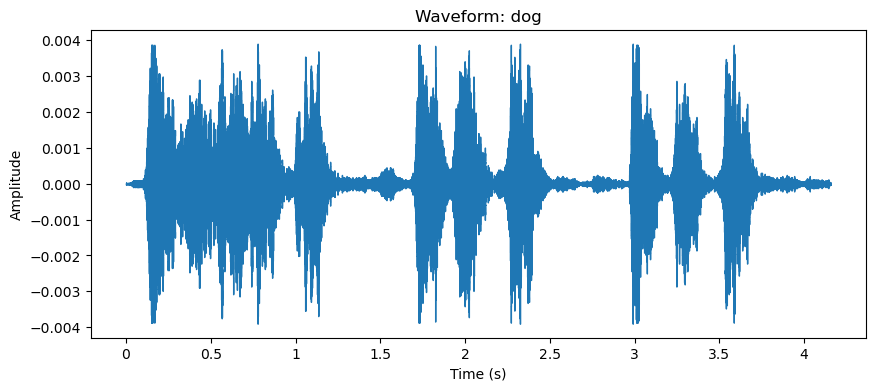

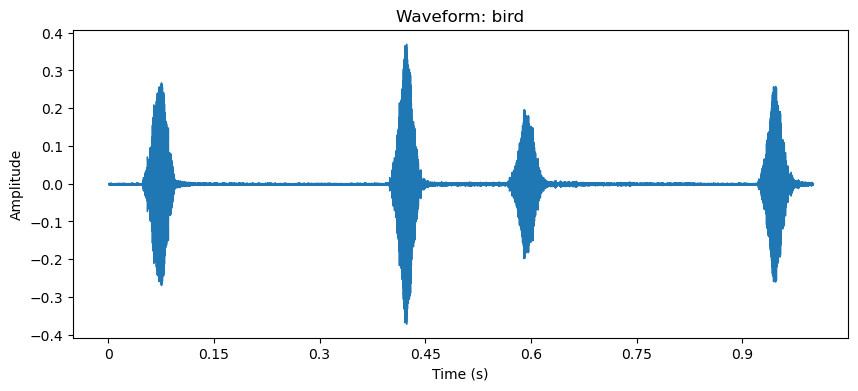

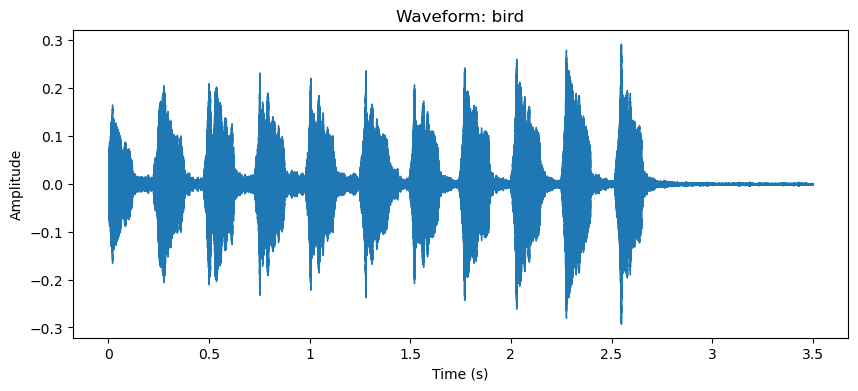

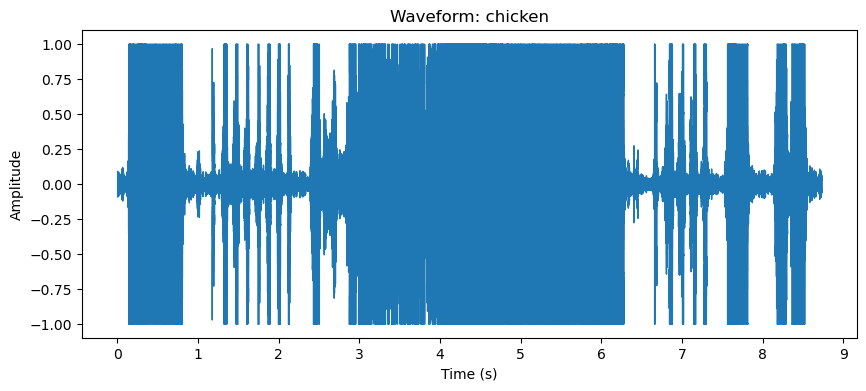

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Sample every 100th audio object
for sample in audio_objects[::100]:
    y = sample.audio_data
    sr = sample.sample_rate
    
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {sample.label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

## Data Preprocessing
Goals:<br>
(1) Convert list of audio files into a dataframe<br>
(2) Extract MFCC<br>
(3) Split train/test<br>

### Convert list of AudioFile objects into dataframe

In [3]:
# Features of interest:
# (file_name, label, audio_data, sample_rate)

# Convert to DataFrame
data = {
    "file_name": [audio_object.file_name for audio_object in audio_objects],
    "audio_data": [audio_object.audio_data for audio_object in audio_objects],
    "sample_rate": [audio_object.sample_rate for audio_object in audio_objects],
    "label": [audio_object.label for audio_object in audio_objects]
}

audio_df = pd.DataFrame(data)

# Display the DataFrame
print(audio_df)

               file_name                                         audio_data  \
0      Aslan\aslan_1.wav  [0.0, 0.0077819824, 0.0, 0.0077819824, 0.0, 0....   
1     Aslan\aslan_10.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     Aslan\aslan_11.wav  [-6.1035156e-05, -6.1035156e-05, -9.1552734e-0...   
3     Aslan\aslan_12.wav  [0.0, 0.0, 0.0, 0.0, -0.00012207031, 0.0001220...   
4     Aslan\aslan_13.wav  [-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...   
...                  ...                                                ...   
1008  Tavuk\tavuk_27.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1009  Tavuk\tavuk_28.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1010   Tavuk\tavuk_3.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1011   Tavuk\tavuk_6.wav  [0.0, -3.0517578e-05, -3.0517578e-05, -3.05175...   
1012   Tavuk\tavuk_7.wav  [-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...   

      sample_rate    label  
0           22050     

In [4]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_name    1013 non-null   object
 1   audio_data   1013 non-null   object
 2   sample_rate  1013 non-null   int64 
 3   label        1013 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.8+ KB


### Mel Spectrogram

In [5]:
import librosa
import numpy as np

def generate_mel_spectrogram(audio_data, sr=22050, n_mels=128, fmax=8000, hop_length=512, win_length=1024):
    S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels, fmax=fmax, hop_length=hop_length, win_length=win_length)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# Generate Mel spectrograms for all audio data in the DataFrame
audio_df['mel_spectrogram'] = audio_df['audio_data'].apply(lambda x: generate_mel_spectrogram(np.array((x))))

In [6]:
# Define a fixed number of frames
max_frames = 100  # Adjust based on your dataset

# Function to pad or truncate
def pad_or_truncate(spec, max_frames):
    if spec.shape[1] < max_frames:
        # Pad with zeros
        padding = ((0, 0), (0, max_frames - spec.shape[1]))
        return np.pad(spec, padding, mode='constant')
    else:
        # Truncate
        return spec[:, :max_frames]

# Apply padding/truncation
audio_df["spectrogram_fixed"] = audio_df["mel_spectrogram"].apply(lambda spec: pad_or_truncate(spec, max_frames))

# Flatten the fixed-length
spec_flattened = [spec.flatten() for spec in audio_df["spectrogram_fixed"]]

# Create a DataFrame with flattened features
spec_columns = [f"spec_{i}" for i in range(max_frames * 128)]
df_spec = pd.concat([audio_df, pd.DataFrame(spec_flattened, columns=spec_columns)], axis=1)

df_spec = df_spec.drop(columns=["mel_spectrogram", "spectrogram_fixed"])

# Display the DataFrame
print(df_spec)

               file_name                                         audio_data  \
0      Aslan\aslan_1.wav  [0.0, 0.0077819824, 0.0, 0.0077819824, 0.0, 0....   
1     Aslan\aslan_10.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     Aslan\aslan_11.wav  [-6.1035156e-05, -6.1035156e-05, -9.1552734e-0...   
3     Aslan\aslan_12.wav  [0.0, 0.0, 0.0, 0.0, -0.00012207031, 0.0001220...   
4     Aslan\aslan_13.wav  [-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...   
...                  ...                                                ...   
1008  Tavuk\tavuk_27.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1009  Tavuk\tavuk_28.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1010   Tavuk\tavuk_3.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1011   Tavuk\tavuk_6.wav  [0.0, -3.0517578e-05, -3.0517578e-05, -3.05175...   
1012   Tavuk\tavuk_7.wav  [-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...   

      sample_rate    label     spec_0     spec_1   

In [7]:
from sklearn.preprocessing import StandardScaler

# Select only the Spec columns
spec_columns = [col for col in df_spec.columns if col.startswith("spec_")]
spec_data = df_spec[spec_columns]

# Normalize using Standardization
scaler = StandardScaler()
spec_normalized = scaler.fit_transform(spec_data)

# Replace the original Spec columns with normalized values
df_spec[spec_columns] = spec_normalized

# Display the DataFrame
print(df_spec.head())

            file_name                                         audio_data  \
0   Aslan\aslan_1.wav  [0.0, 0.0077819824, 0.0, 0.0077819824, 0.0, 0....   
1  Aslan\aslan_10.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  Aslan\aslan_11.wav  [-6.1035156e-05, -6.1035156e-05, -9.1552734e-0...   
3  Aslan\aslan_12.wav  [0.0, 0.0, 0.0, 0.0, -0.00012207031, 0.0001220...   
4  Aslan\aslan_13.wav  [-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...   

   sample_rate label    spec_0    spec_1    spec_2    spec_3    spec_4  \
0        22050  lion  0.727722  0.518486  0.337280  0.020162 -0.174803   
1        11025  lion  0.746909  0.544771  0.512792  0.767887  0.648546   
2        11025  lion  0.910972  0.912046  0.658911  0.628510  0.641093   
3        11025  lion  2.069166  1.962673  1.796961  1.721306  1.724231   
4        11025  lion -0.122356 -0.161139 -0.406763 -0.512097 -0.408717   

     spec_5  ...  spec_12790  spec_12791  spec_12792  spec_12793  spec_12794  \
0 -0.693044  ...  

In [8]:
df_spec.to_csv('audio_data2_spectrogram.csv', index=False)

### MFCC

In [5]:
# Function to extract MFCC features
def extract_mfcc(audio_data, sample_rate, n_mfcc=13):
    return librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)

# Add MFCC features to the DataFrame
audio_df["mfcc"] = audio_df.apply(lambda row: extract_mfcc(row["audio_data"], row["sample_rate"]), axis=1)

# Display the DataFrame
print(audio_df)

               file_name                                         audio_data  \
0      Aslan\aslan_1.wav  [0.0, 0.0077819824, 0.0, 0.0077819824, 0.0, 0....   
1     Aslan\aslan_10.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     Aslan\aslan_11.wav  [-6.1035156e-05, -6.1035156e-05, -9.1552734e-0...   
3     Aslan\aslan_12.wav  [0.0, 0.0, 0.0, 0.0, -0.00012207031, 0.0001220...   
4     Aslan\aslan_13.wav  [-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...   
...                  ...                                                ...   
1008  Tavuk\tavuk_27.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1009  Tavuk\tavuk_28.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1010   Tavuk\tavuk_3.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1011   Tavuk\tavuk_6.wav  [0.0, -3.0517578e-05, -3.0517578e-05, -3.05175...   
1012   Tavuk\tavuk_7.wav  [-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...   

      sample_rate    label                         

In [6]:
# Flatten MFCC features into separate columns
mfcc_flattened = [mfcc.flatten() for mfcc in audio_df["mfcc"]]

# Determine the maximum number of MFCC coefficients
max_mfcc_length = max(len(mfcc) for mfcc in mfcc_flattened)

# Create a DataFrame with flattened MFCC features
mfcc_columns = [f"mfcc_{i}" for i in range(max_mfcc_length)]
mfcc_data = {col: [] for col in mfcc_columns}

for mfcc in mfcc_flattened:
    for i, value in enumerate(mfcc):
        mfcc_data[f"mfcc_{i}"].append(value)
    # Pad with NaN if necessary
    for i in range(len(mfcc), max_mfcc_length):
        mfcc_data[f"mfcc_{i}"].append(np.nan)

# Add flattened MFCC features to the original DataFrame
df_mfcc = pd.concat([audio_df, pd.DataFrame(mfcc_data)], axis=1)

# Drop the original "mfcc" column (optional)
df_mfcc = df_mfcc.drop(columns=["mfcc"])

# Display the DataFrame
print(df_mfcc)
print(df_mfcc.info())

               file_name                                         audio_data  \
0      Aslan\aslan_1.wav  [0.0, 0.0077819824, 0.0, 0.0077819824, 0.0, 0....   
1     Aslan\aslan_10.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     Aslan\aslan_11.wav  [-6.1035156e-05, -6.1035156e-05, -9.1552734e-0...   
3     Aslan\aslan_12.wav  [0.0, 0.0, 0.0, 0.0, -0.00012207031, 0.0001220...   
4     Aslan\aslan_13.wav  [-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...   
...                  ...                                                ...   
1008  Tavuk\tavuk_27.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1009  Tavuk\tavuk_28.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1010   Tavuk\tavuk_3.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1011   Tavuk\tavuk_6.wav  [0.0, -3.0517578e-05, -3.0517578e-05, -3.05175...   
1012   Tavuk\tavuk_7.wav  [-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...   

      sample_rate    label      mfcc_0      mfcc_1 

Flattened mfcc had 7305 columns, which are full of NaN near the end. <br>
Solution: truncate flattened mfcc

In [7]:
import numpy as np

# Define a fixed number of frames
max_frames = 100  # Adjust based on your dataset

# Function to pad or truncate MFCCs
def pad_or_truncate(mfcc, max_frames):
    if mfcc.shape[1] < max_frames:
        # Pad with zeros
        padding = ((0, 0), (0, max_frames - mfcc.shape[1]))
        return np.pad(mfcc, padding, mode='constant')
    else:
        # Truncate
        return mfcc[:, :max_frames]

# Apply padding/truncation to MFCCs
audio_df["mfcc_fixed"] = audio_df["mfcc"].apply(lambda mfcc: pad_or_truncate(mfcc, max_frames))

# Flatten the fixed-length MFCCs
mfcc_flattened = [mfcc.flatten() for mfcc in audio_df["mfcc_fixed"]]

# Create a DataFrame with flattened MFCC features
mfcc_columns = [f"mfcc_{i}" for i in range(max_frames * 13)]  # 13 is the default number of MFCCs
df_mfcc = pd.concat([audio_df, pd.DataFrame(mfcc_flattened, columns=mfcc_columns)], axis=1)

# Drop the original "mfcc" and "mfcc_fixed" columns (optional)
df_mfcc = df_mfcc.drop(columns=["mfcc", "mfcc_fixed"])

# Display the DataFrame
print(df_mfcc)

               file_name                                         audio_data  \
0      Aslan\aslan_1.wav  [0.0, 0.0077819824, 0.0, 0.0077819824, 0.0, 0....   
1     Aslan\aslan_10.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     Aslan\aslan_11.wav  [-6.1035156e-05, -6.1035156e-05, -9.1552734e-0...   
3     Aslan\aslan_12.wav  [0.0, 0.0, 0.0, 0.0, -0.00012207031, 0.0001220...   
4     Aslan\aslan_13.wav  [-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...   
...                  ...                                                ...   
1008  Tavuk\tavuk_27.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1009  Tavuk\tavuk_28.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1010   Tavuk\tavuk_3.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05,...   
1011   Tavuk\tavuk_6.wav  [0.0, -3.0517578e-05, -3.0517578e-05, -3.05175...   
1012   Tavuk\tavuk_7.wav  [-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...   

      sample_rate    label      mfcc_0      mfcc_1 

### Normalization

In [8]:
from sklearn.preprocessing import StandardScaler

# Select only the MFCC columns
mfcc_columns = [col for col in df_mfcc.columns if col.startswith("mfcc_")]
mfcc_data = df_mfcc[mfcc_columns]

# Normalize using Standardization
scaler = StandardScaler()
mfcc_normalized = scaler.fit_transform(mfcc_data)

# Replace the original MFCC columns with normalized values
df_mfcc[mfcc_columns] = mfcc_normalized

# Display the DataFrame
print(df_mfcc.head())

            file_name                                         audio_data  \
0   Aslan\aslan_1.wav  [0.0, 0.0077819824, 0.0, 0.0077819824, 0.0, 0....   
1  Aslan\aslan_10.wav  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  Aslan\aslan_11.wav  [-6.1035156e-05, -6.1035156e-05, -9.1552734e-0...   
3  Aslan\aslan_12.wav  [0.0, 0.0, 0.0, 0.0, -0.00012207031, 0.0001220...   
4  Aslan\aslan_13.wav  [-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...   

   sample_rate label    mfcc_0    mfcc_1    mfcc_2    mfcc_3    mfcc_4  \
0        22050  lion  0.346268  0.294345  0.164464  0.111703  0.053387   
1        11025  lion  0.733720  0.996847  0.971137  0.945886  1.068231   
2        11025  lion -1.314638 -1.088996 -1.039382 -1.132675 -1.256559   
3        11025  lion  0.711537  0.388524 -0.048357 -0.163799 -0.094296   
4        11025  lion  0.292743  0.383896  0.656798  0.966672  1.240376   

     mfcc_5  ...  mfcc_1290  mfcc_1291  mfcc_1292  mfcc_1293  mfcc_1294  \
0  0.032606  ...   0.59

### Write into CSV file

In [9]:
df_mfcc.to_csv('audio_data2.csv', index=False)